# Using quandl zillow api for Chicago and Evanston Home Sale Prices using ARIMA and EWMAs

This post includes code adapted from [python for finance and trading algorithms udemy course](https://udemy.com/python-for-finance-and-trading-algorithms/) and [python for finance and trading algorithms udemy course notebooks](https://github.com/theoneandonlywoj/Python-for-Financial-Analysis-and-Algorithmic-Trading).

Find the quandl api documentation here -

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl


%matplotlib inline

In [4]:
quandl_call = (
    "ZILLOW/{category}{code}_{indicator}"
)


def download_data(category, code, indicator):
    """
    Reads in a single dataset from the John Hopkins GitHub repo
    as a DataFrame
    
    Parameters
    ----------
    category : "Chicago_Area" or "Evanston"
    
    code : "Evanston" or "Chicago"
    
    indicator : "Sales_Price" or "other"

    
    Returns
    -------
    DataFrame
    """
    AREA_CATEGORY_dict = {"Evanston": "C", "Chicago_Area": "C"}
    AREA_CODE_dict = {"Evanston": "64604", "Chicago": "36156"}
    INDICATOR_CODE_dict = {"Sales_Price": "SP"}
    
    
    
    category = AREA_CATEGORY_dict[category]
    code = AREA_CODE_dict[code]
    indicator = INDICATOR_CODE_dict[indicator]

    
    
    return quandl.get(quandl_call.format(category=category, code=code, indicator=indicator))

In [5]:
df = download_data('Chicago_Area', 'Evanston', 'Sales_Price')

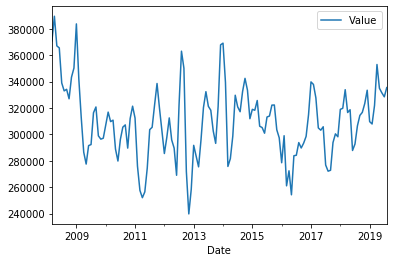

In [7]:
df.plot()

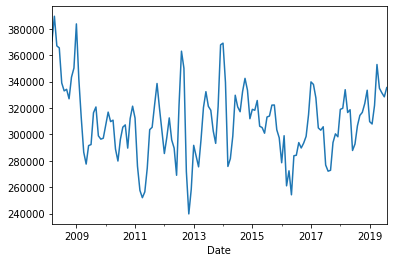

In [8]:
df['Value'].plot(label='Evanston House Prices')

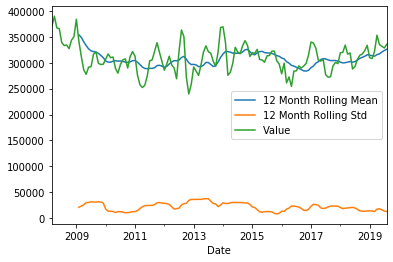

In [14]:
timeseries = df['Value']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

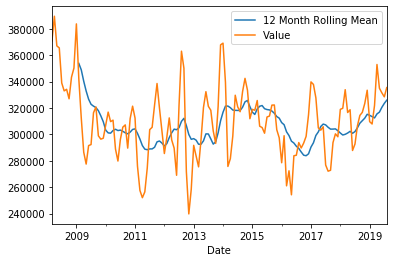

In [12]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

/home/gao/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 432x288 with 0 Axes>

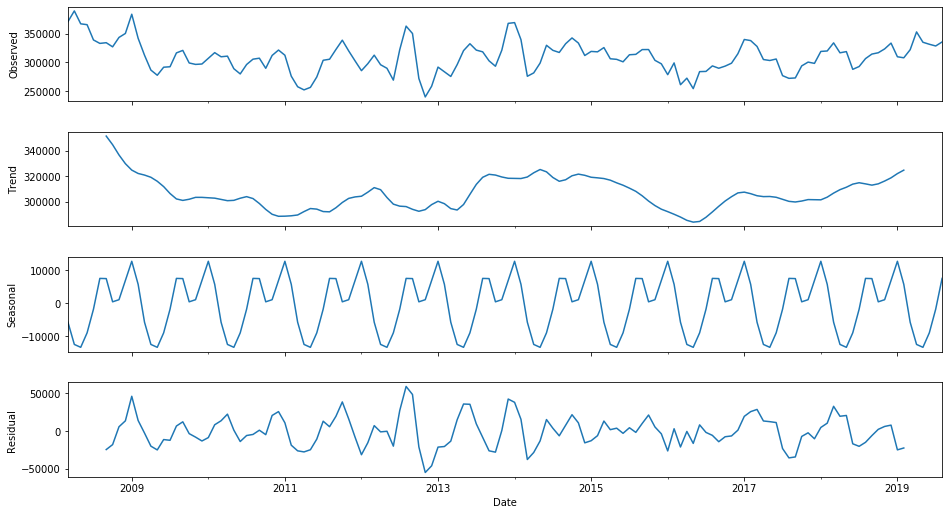

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Value'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [18]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [19]:
model = sm.tsa.statespace.SARIMAX(df['Value'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/home/gao/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  138
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1441.360
Date:                            Mon, 26 Oct 2020   AIC                           2888.719
Time:                                    06:57:44   BIC                           2897.204
Sample:                                03-31-2008   HQIC                          2892.166
                                     - 08-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3461      0.072      4.832      0.000       0.206       0.487
ma.S.L12      -0.8710      0.113   

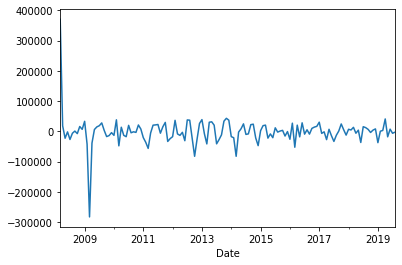

In [20]:
results.resid.plot()

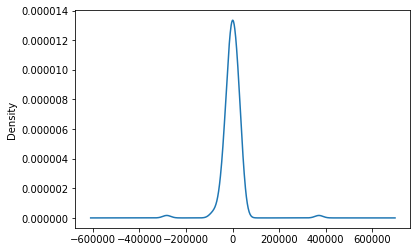

In [21]:
results.resid.plot(kind='kde')

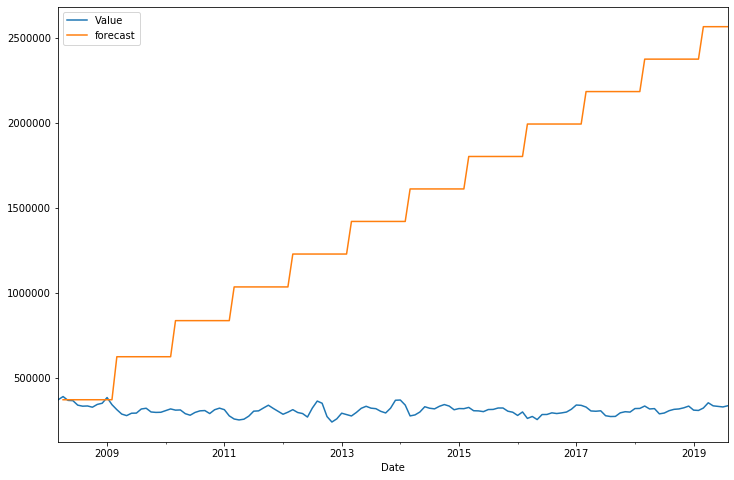

In [26]:
df['forecast'] = results.predict(start = 1, end= 200, dynamic= True)  
df[['Value','forecast']].plot(figsize=(12,8))

In [28]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24) ]

In [29]:
future_dates

[Timestamp('2019-08-31 00:00:00'),
 Timestamp('2019-09-30 00:00:00'),
 Timestamp('2019-10-31 00:00:00'),
 Timestamp('2019-11-30 00:00:00'),
 Timestamp('2019-12-31 00:00:00'),
 Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-02-29 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-04-30 00:00:00'),
 Timestamp('2020-05-31 00:00:00'),
 Timestamp('2020-06-30 00:00:00'),
 Timestamp('2020-07-31 00:00:00'),
 Timestamp('2020-08-31 00:00:00'),
 Timestamp('2020-09-30 00:00:00'),
 Timestamp('2020-10-31 00:00:00'),
 Timestamp('2020-11-30 00:00:00'),
 Timestamp('2020-12-31 00:00:00'),
 Timestamp('2021-01-31 00:00:00'),
 Timestamp('2021-02-28 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-04-30 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-30 00:00:00'),
 Timestamp('2021-07-31 00:00:00')]

In [30]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [31]:
future_df = pd.concat([df,future_dates_df])

In [35]:
future_df.head()

,Value,forecast
2008-03-31,370900.0,NaN
2008-04-30,389600.0,370900.0
2008-05-31,367100.0,370900.0
2008-06-30,365600.0,370900.0
2008-07-31,339000.0,370900.0


In [34]:
future_df.tail()

,Value,forecast
2021-03-31,NaN,NaN
2021-04-30,NaN,NaN
2021-05-31,NaN,NaN
2021-06-30,NaN,NaN
2021-07-31,NaN,NaN


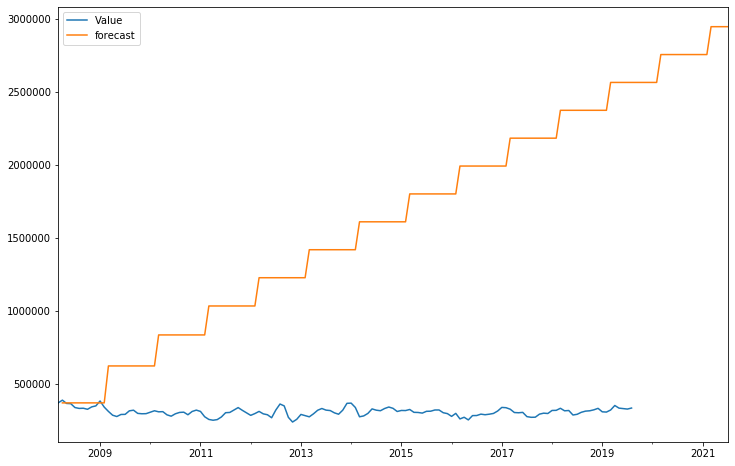

In [36]:
future_df['forecast'] = results.predict(start = 1, end = 720, dynamic= True)  
future_df[['Value', 'forecast']].plot(figsize=(12, 8)) 

## Exponentially-weighted moving averages

In [37]:
df['6-month-SMA']=df['Value'].rolling(window=6).mean()
df['12-month-SMA']=df['Value'].rolling(window=12).mean()

In [38]:
df['EWMA12'] = df['Value'].ewm(span=12).mean()

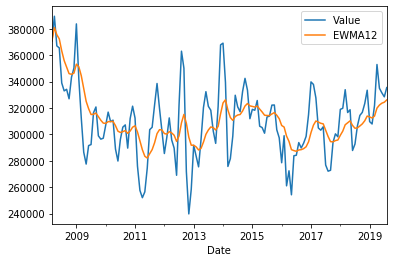

In [40]:
df[['Value','EWMA12']].plot()

## Getting at the trend by removing the cyclical elements of Housing Prices

In [41]:
# Tuple unpacking
df_cycle, df_trend = sm.tsa.filters.hpfilter(df.Value)

In [42]:
df_cycle

Date
2008-03-31     1942.830509
2008-04-30    24797.247533
2008-05-31     6450.450288
2008-06-30     9085.726225
2008-07-31   -13417.668736
                  ...     
2019-04-30    25876.617108
2019-05-31     6082.075050
2019-06-30      789.779248
2019-07-31    -4001.523626
2019-08-31     1206.419488
Name: Value, Length: 138, dtype: float64

In [43]:
df["trend"] = df_trend

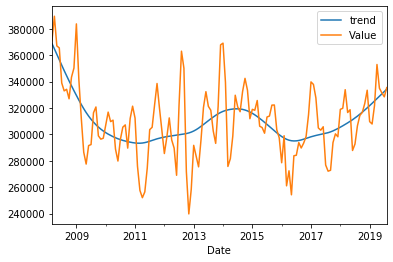

In [44]:
df[['trend','Value']].plot()

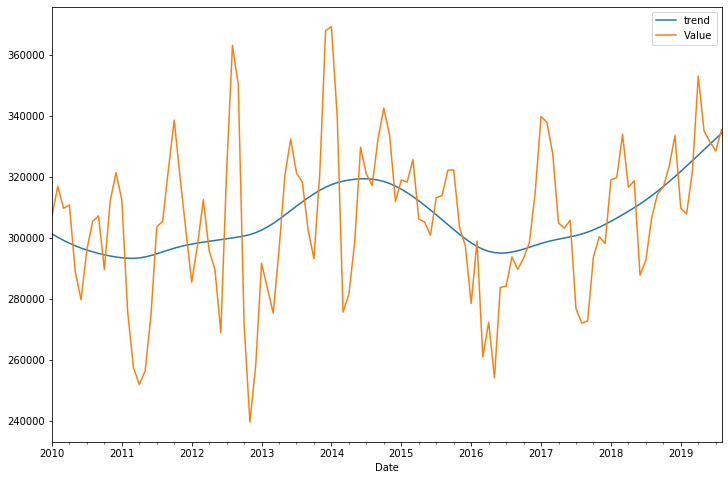

In [45]:
df[['trend','Value']]["2010-01-31":].plot(figsize=(12,8))

## Chicago and Evanston Home Sale Prices

In [46]:
EV_SP = download_data('Chicago_Area', 'Evanston', 'Sales_Price')
CH_SP = download_data('Chicago_Area', 'Chicago', 'Sales_Price')

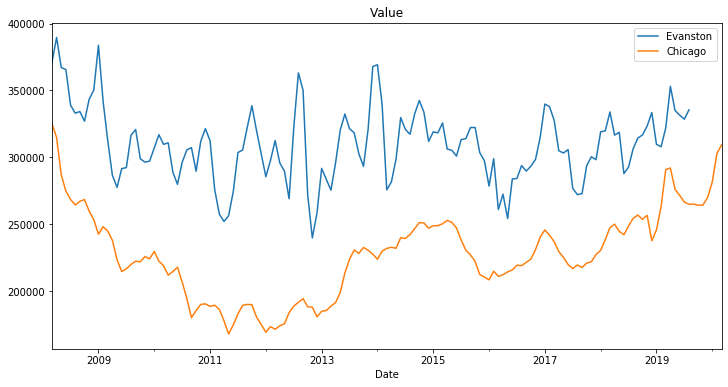

In [47]:
fig = plt.figure(figsize=(12, 6))
plt.title('Value')

EV_SP['Value'].plot(label='Evanston')
CH_SP['Value'].plot(label='Chicago')

plt.legend()

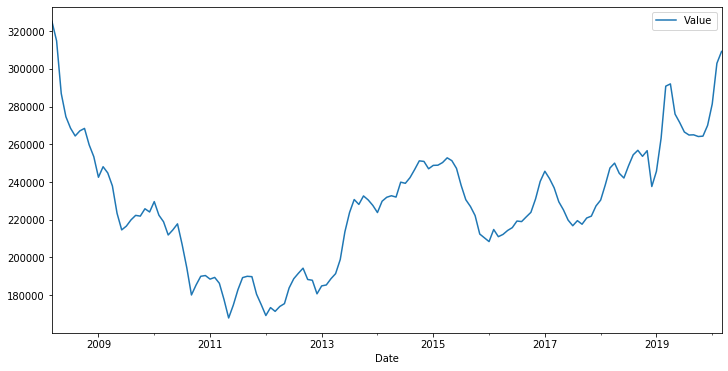

In [48]:
CH_SP.plot(figsize=(12,6))